# Installing and Importing and Initializing Libraries.

In [ ]:
!pip install pandarallel

In [1]:
import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
#from pandarallel import pandarallel
import plotly.express as px
import tensorflow as tf
import matplotlib.pyplot as plt
pd.set_option('display.max_row', 500)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from tqdm import tqdm
tqdm.pandas()
#pandarallel.initialize(progress_bar=True)

/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


# Reading the Datasets.

In [2]:
df_series=pd.read_parquet(path="/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet", engine='auto')

In [3]:
df_events=pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
events=df_events[['series_id', 'step','event']]

# Merging the Datasets to train the model

In [4]:
series_df=pd.merge(df_series,events,on=["step","series_id"],how='left')
series_df['sleep']=np.nan
series_df.loc[series_df["event"]=="onset", "sleep"] = 1
series_df.loc[series_df["event"]=="wakeup", "sleep"] = 0
series_df['sleep'].fillna(method='ffill', inplace=True)
series_df['sleep'].fillna(value=0, inplace=True)
df_series=[]

In [ ]:
series_df

# Windowing the training data
### As the target is to detect an event, 
### So, extracting timesteps 30 min before and after the events. 

In [5]:
def window(df, win_size):
    ind=df.index[df['event'].isna()==False]
    c=0
    df['window']=np.nan
    for i in tqdm(ind):
        a=i-win_size
        b=i+win_size
        df['window'].loc[a:i]=int(c)
        c=c+1
        df['window'].loc[i:b]=int(c)
        c=c+1
    df['window'].dropna(inplace=True)
    return df[df['window'].isna()==False]
win_size=360
df_series=window(series_df,win_size)
#df_series=df_series[df_series['window'].isna()==False]

100%|██████████| 9585/9585 [00:06<00:00, 1547.13it/s]


# Removing the steps where change in enmo and anglez is insignificant (device is supposed not to be worn)

In [6]:
def inactive_periods(df_series):
    print("shape before application: ",df_series.shape)
    df_series['diff_enmo']=df_series['enmo'].diff()
    df_series['diff_anglez']=df_series['anglez'].diff()
    df_series=df_series[(df_series['diff_enmo']!=0.0) & (df_series['diff_anglez']!=0.0)]
    print("shape after application: ",df_series.shape)
    df_series.drop('diff_enmo', inplace=True, axis=1)
    df_series.drop('diff_anglez', inplace=True, axis=1)
    print("shape after completion: ",df_series.shape)
    print("removed ")
    return df_series
df_series=inactive_periods(df_series)

shape before application:  (6910640, 8)
shape after application:  (3929682, 10)
shape after completion:  (3929682, 8)
removed 


In [21]:
df_series.drop('diff_enmo', inplace=True, axis=1)
df_series.drop('diff_anglez', inplace=True, axis=1)

# Clustering the Enmo and Anglez

In [7]:
def clustering(df):
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler    
    X=df[['anglez','enmo']]
#Scalling the data
    scaler=StandardScaler()
    X_scaled=scaler.fit_transform(X)
#perform clustering
    model=KMeans(n_clusters=4 )
    model.fit(X_scaled)
    return model.labels_


In [8]:
df_series['cluster']=(clustering(df_series)+1)/4

In [26]:
df_series['series_id'].unique()

array(['038441c925bb', '03d92c9f6f8a', '0402a003dae9', '04f547b8017d',
       '05e1944c3818', '062cae666e2a', '062dbd4c95e6', '08db4255286f',
       '0a96f4993bd7', '0cd1e3d0ed95', '0ce74d6d2106', '0cfc06c129cc',
       '0d0ad1e77851', '0dee4fda51c3', '0ec9fc461819', '0ef7d94fde99',
       '0f572d690310', '10469f6765bf', '1087d7b0ff2e', '10f8bc1f7b07',
       '12d01911d509', '1319a1935f48', '137771d19ca2', '137b99e936ab',
       '13b4d6a01d27', '148471991ffb', '154fe824ed87', '16fe2798ed0f',
       '1716cd4163b2', '1762ab70ec76', '188d4b7cd28b', '18a0ca03431d',
       '18b61dd5aae8', '1955d568d987', '1b92be89db4c', '1c7c0bad1263',
       '1d4569cbac0f', '1e6717d93c1d', '1f96b9668bdf', '207eded97727',
       '25e2b3dd9c3b', '2654a87be968', '27f09a6a858f', '280e08693c6d',
       '292a75c0b94e', '29c75c018220', '29d3469bd15d', '2b0a1fa8eba8',
       '2b8d87addea9', '2cd2340ca14d', '2e9ced2c7976', '2f7504d0f426',
       '2fbbee1a38e3', '31011ade7c0a', '3318a0e3ed6f', '33ceeba8918a',
      

# Adding Rolling Standard Deviations

- As per observation enmo and anglez varies frequently and more than normal for few timesteps before and after the event.
- In order to consider the variations into the modelling, using the method.

In [47]:
def rollingstd(df):
    df['sd_anglez_1']=np.nan
    df['sd_enmo_1']=np.nan 
    for series_id in tqdm(df['series_id'].unique()):
        df['sd_anglez_1']=df['anglez'][df['series_id']==series_id].rolling(window=12).std()
        df['sd_enmo_1']=df['enmo'][df['series_id']==series_id].rolling(window=12).std()
        df['sd_anglez_1'][df['series_id']==series_id].fillna(df['anglez'][df['series_id']==series_id].rolling(window=1).std(),inplace=True)
        df['sd_enmo_1'][df['series_id']==series_id].fillna(df['enmo'][df['series_id']==series_id].rolling(window=1).std(),inplace=True)
   # df['sleep'] = df['sleep'].replace({0:False, 1:True})
    df['sd_anglez_1'].fillna(0.0,inplace=True)
    df['sd_enmo_1'].fillna(0.0,inplace=True)
    return(df)


In [ ]:
series_df=rollingstd(df_series)
series_df['sd_anglez_1']=pd.to_numeric(series_df['sd_anglez_1'])
series_df['sd_enmo_1']=pd.to_numeric(series_df['sd_anglez_1'])
series_df[['sleep']]=series_df[['sleep']].astype(int)

 57%|█████▋    | 154/269 [03:58<02:59,  1.56s/it]

In [28]:
series_df.dtypes

series_id       object
step            uint32
timestamp       object
anglez         float32
enmo           float32
event           object
sleep            int64
window         float64
cluster        float64
sd_anglez_1    float64
sd_enmo_1      float64
dtype: object

In [31]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X=series_df[['sd_anglez_1','sd_enmo_1','anglez','enmo','cluster']]
y=series_df[['sleep']]
X_scaled=X
#scaler=preprocessing.MinMaxScaler().fit(X)
#X_scaled= scaler.transform(X)
X_train, X_test, y_train, y_test =train_test_split(X_scaled,y,test_size=0.2, random_state=42)

In [42]:
y_train[['sleep']].value_counts()

sleep
0        2237372
1         906373
Name: count, dtype: int64

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf =RandomForestClassifier(n_jobs=-1,verbose=1) 
print ('Training the model')
rf.fit(X_train,y_train)
print ('Saving the model')
#from joblib import dump, load
#dump(rf, 'rf_model.joblib')
y_pred=rf.predict(X_test)
evaluate(y_test,y_pred)

Training the model


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
X_train.shape[1]
input_size=X_train.shape[1]*win_size


In [30]:
model_nn=tf.keras.Sequential([
  tf.keras.layers.Dense(360,input_shape=[X_train.shape[1]]),
  tf.keras.layers.Dense(360,activation=tf.nn.leaky_relu, use_bias=True),
  tf.keras.layers.Dense(180,activation=tf.nn.relu),
  tf.keras.layers.Dense(90,activation=tf.nn.relu),
  tf.keras.layers.Dense(20,activation=tf.nn.leaky_relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])
#model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001) , 
#                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
#                metrics=['accuracy'])



In [31]:
epochs = 100
batch_size = win_size

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.x", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=epochs, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=epochs, verbose=1),
]
model_nn.compile(
    optimizer="adam",
    #loss="sparse_categorical_crossentropy",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['binary_accuracy'],
)
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 360)               2160      
                                                                 
 dense_1 (Dense)             (None, 360)               129960    
                                                                 
 dense_2 (Dense)             (None, 180)               64980     
                                                                 
 dense_3 (Dense)             (None, 90)                16290     
                                                                 
 dense_4 (Dense)             (None, 20)                1820      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 215231 (840.75 KB)
Trainable params: 21523

In [ ]:
y_train.dtypes

In [32]:
history = model_nn.fit(
    X_train,
    y_train,
    batch_size=360,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
6948/6948 [==============================] - 87s 12ms/step - loss: 0.3938 - binary_accuracy: 0.8523 - val_loss: 0.3816 - val_binary_accuracy: 0.8544 - lr: 0.0010
Epoch 2/100
6948/6948 [==============================] - 72s 10ms/step - loss: 0.3828 - binary_accuracy: 0.8534 - val_loss: 0.3799 - val_binary_accuracy: 0.8542 - lr: 0.0010
Epoch 3/100
6948/6948 [==============================] - 74s 11ms/step - loss: 0.3809 - binary_accuracy: 0.8535 - val_loss: 0.3797 - val_binary_accuracy: 0.8545 - lr: 0.0010
Epoch 4/100
6948/6948 [==============================] - 72s 10ms/step - loss: 0.3800 - binary_accuracy: 0.8535 - val_loss: 0.3773 - val_binary_accuracy: 0.8546 - lr: 0.0010
Epoch 5/100
6948/6948 [==============================] - 76s 11ms/step - loss: 0.3796 - binary_accuracy: 0.8536 - val_loss: 0.3766 - val_binary_accuracy: 0.8547 - lr: 0.0010
Epoch 6/100
6948/6948 [==============================] - 75s 11ms/step - loss: 0.3793 - binary_accuracy: 0.8536 - val_loss: 0.3797

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6948/6948 [==============================] - 73s 10ms/step - loss: 0.3772 - binary_accuracy: 0.8538 - val_loss: 0.3751 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 30/100
6948/6948 [==============================] - 71s 10ms/step - loss: 0.3771 - binary_accuracy: 0.8538 - val_loss: 0.3755 - val_binary_accuracy: 0.8549 - lr: 0.0010
Epoch 31/100
6948/6948 [==============================] - 75s 11ms/step - loss: 0.3771 - binary_accuracy: 0.8538 - val_loss: 0.3756 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 32/100
 575/6948 [=>............................] - ETA: 58s - loss: 0.3776 - binary_accuracy: 0.8536

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6948/6948 [==============================] - 71s 10ms/step - loss: 0.3770 - binary_accuracy: 0.8539 - val_loss: 0.3755 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 33/100
6948/6948 [==============================] - 71s 10ms/step - loss: 0.3770 - binary_accuracy: 0.8539 - val_loss: 0.3753 - val_binary_accuracy: 0.8549 - lr: 0.0010
Epoch 34/100
6948/6948 [==============================] - 73s 10ms/step - loss: 0.3769 - binary_accuracy: 0.8539 - val_loss: 0.3750 - val_binary_accuracy: 0.8549 - lr: 0.0010
Epoch 35/100
3437/6948 [=============>................] - ETA: 32s - loss: 0.3773 - binary_accuracy: 0.8539

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6948/6948 [==============================] - 71s 10ms/step - loss: 0.3769 - binary_accuracy: 0.8539 - val_loss: 0.3776 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 37/100
6948/6948 [==============================] - 72s 10ms/step - loss: 0.3768 - binary_accuracy: 0.8539 - val_loss: 0.3747 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 38/100
6849/6948 [============================>.] - ETA: 0s - loss: 0.3767 - binary_accuracy: 0.8539

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6948/6948 [==============================] - 76s 11ms/step - loss: 0.3768 - binary_accuracy: 0.8539 - val_loss: 0.3749 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 40/100
6948/6948 [==============================] - 75s 11ms/step - loss: 0.3768 - binary_accuracy: 0.8539 - val_loss: 0.3748 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 41/100
6948/6948 [==============================] - 72s 10ms/step - loss: 0.3767 - binary_accuracy: 0.8539 - val_loss: 0.3744 - val_binary_accuracy: 0.8549 - lr: 0.0010
Epoch 42/100
2988/6948 [===========>..................] - ETA: 36s - loss: 0.3760 - binary_accuracy: 0.8542

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6948/6948 [==============================] - 74s 11ms/step - loss: 0.3767 - binary_accuracy: 0.8540 - val_loss: 0.3755 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 44/100
6948/6948 [==============================] - 71s 10ms/step - loss: 0.3767 - binary_accuracy: 0.8539 - val_loss: 0.3759 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 45/100
6948/6948 [==============================] - 71s 10ms/step - loss: 0.3766 - binary_accuracy: 0.8539 - val_loss: 0.3772 - val_binary_accuracy: 0.8549 - lr: 0.0010
Epoch 46/100
6948/6948 [==============================] - 72s 10ms/step - loss: 0.3766 - binary_accuracy: 0.8539 - val_loss: 0.3752 - val_binary_accuracy: 0.8550 - lr: 0.0010
Epoch 47/100
6948/6948 [==============================] - 72s 10ms/step - loss: 0.3766 - binary_accuracy: 0.8539 - val_loss: 0.3747 - val_binary_accuracy: 0.8549 - lr: 0.0010
Epoch 48/100
6948/6948 [==============================] - 71s 10ms/step - loss: 0.3766 - binary_accuracy: 0.8539 - val_loss: 0.3755 - val_

In [ ]:
model = tf.keras.models.load_model("best_model.x")


In [34]:
model = tf.keras.models.load_model("best_model.x")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

24425/24425 [==============================] - 54s 2ms/step - loss: 0.3749 - binary_accuracy: 0.8546
Test accuracy 0.8545605540275574
Test loss 0.3749106824398041


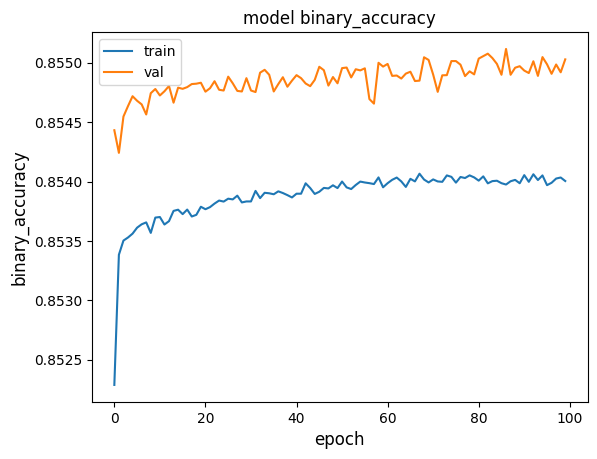

In [35]:
metric = "binary_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [37]:
test=pd.read_parquet(path="/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet", engine='auto')

In [ ]:
test_df=test

In [38]:

test=inactive_periods(test)
test_df=test
test_df['cluster']=(clustering(test_df)+1)/4
test_df=rollingstd(test_df)
test_df['sd_anglez_1']=pd.to_numeric(test_df['sd_anglez_1'])
test_df['sd_enmo_1']=pd.to_numeric(test_df['sd_anglez_1'])
X=test_df[['sd_anglez_1','sd_enmo_1','anglez','enmo','cluster']]
y=np.absolute(model.predict(X))


shape before application:  (450, 5)
shape after application:  (296, 7)
shape after completion:  (296, 7)
removed 
10/10 [==============================] - 0s 2ms/step


In [39]:
y

array([[0.9478585 ],
       [0.94733036],
       [0.94759524],
       [0.94679725],
       [0.9478585 ],
       [0.9495358 ],
       [0.9482084 ],
       [0.9507584 ],
       [0.94750345],
       [0.9479458 ],
       [0.9476831 ],
       [0.06991411],
       [0.09934929],
       [0.08537974],
       [0.12317809],
       [0.08964051],
       [0.1241418 ],
       [0.11398411],
       [0.10067558],
       [0.09750229],
       [0.03498211],
       [0.25994164],
       [0.31229934],
       [0.35027045],
       [0.36881512],
       [0.37906855],
       [0.36616462],
       [0.32994273],
       [0.30758214],
       [0.27796036],
       [0.23241422],
       [0.18708   ],
       [0.9178051 ],
       [0.9184652 ],
       [0.91828334],
       [0.91891795],
       [0.9174845 ],
       [0.9169998 ],
       [0.9167023 ],
       [0.9173426 ],
       [0.9172094 ],
       [0.91719174],
       [0.91820985],
       [0.9173175 ],
       [0.91762334],
       [0.9180176 ],
       [0.9179135 ],
       [0.918

In [ ]:
test['sleep']=int(y)